# **Does the number of domains a student is interested in relate to their comfort level (rated 1–5) in programming, mathematics, or statistics?** 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

sns.set(style="whitegrid", context="notebook")

In [4]:
# 1. Data Ingestion

background = pd.read_csv("../data/background-clean.csv")
interest = pd.read_csv("../data/interest-clean.csv")

In [5]:
# 2. Feature Engineering: Calculate Domain Diversity Score (DDS)

# Split semicolon-separated domains (dom column in interest data)
interest_expanded = interest.assign(dom=interest['dom'].str.split(';'))
interest_expanded = interest_expanded.explode('dom')
interest_expanded['dom'] = interest_expanded['dom'].str.strip() 

# One-hot encode and aggregate to count unique domains
domain_dummies = pd.get_dummies(interest_expanded['dom'], prefix='domain')
interest_onehot = pd.concat([interest_expanded[['response_id']], domain_dummies], axis=1)
interest_onehot = interest_onehot.groupby('response_id').max().reset_index()

domain_cols_for_sum = [col for col in interest_onehot.columns if col.startswith('domain_')]
interest_onehot['num_domains'] = interest_onehot[domain_cols_for_sum].sum(axis=1).astype(int)

In [6]:
# 3. Merge DataFrames and Calculate Composite Comfort Index (CCI)

# Merge comfort scores (background) and DDS (interest_onehot)
merged = pd.merge(background, interest_onehot[['response_id', 'num_domains']], on='response_id', how='inner')

# Calculate the Composite Comfort Index (CCI) – the average comfort score
merged['cci'] = merged[['prog.comf', 'math.comf', 'stat.comf']].mean(axis=1)


In [7]:
# 4. Prepare Data for Prediction Model

# X: Domain Diversity Score 
X = merged[["num_domains"]] 
# Y: Composite Comfort Index (the target to predict)
Y = merged['cci']

# Split data into training and testing sets (70/30 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [8]:
# 5. Train the Predictive Model (Decision Tree Regressor)

# Initialize and train the model
dt_model = DecisionTreeRegressor(random_state=42, max_depth=3) # Limit depth for simplicity
dt_model.fit(X_train, Y_train)

# Make predictions
Y_pred = dt_model.predict(X_test)
Y_train_pred = dt_model.predict(X_train)

In [9]:
# 6. Evaluate Predictive Performance

r2_test = r2_score(Y_test, Y_pred)
r2_train = r2_score(Y_train, Y_train_pred)
# Calculate RMSE manually by taking the square root of MSE
# This avoids using the 'squared' parameter which isn't available in older scikit-learn versions
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred))

print("\n--- Decision Tree Regressor Model Evaluation ---")
print(f"R-squared (Training): {r2_train:.4f}")
print(f"R-squared (Test): {r2_test:.4f}")
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test:.4f}")



--- Decision Tree Regressor Model Evaluation ---
R-squared (Training): 0.2781
R-squared (Test): -0.3937
Root Mean Squared Error (RMSE) on Test Set: 0.7165


The model’s training R-squared was moderate (0.2781), indicating limited explanatory power on training data.
 
The test R-squared was negative (-0.3937), suggesting the model poorly generalizes to unseen data and performs worse than predicting the mean.

RMSE of approximately 0.72 indicates prediction errors in comfort level units.

These results suggest that the number of domains a student is interested in does not strongly predict their comfort level in programming, math, or statistics in this dataset.

/Users/bahaarahuja/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


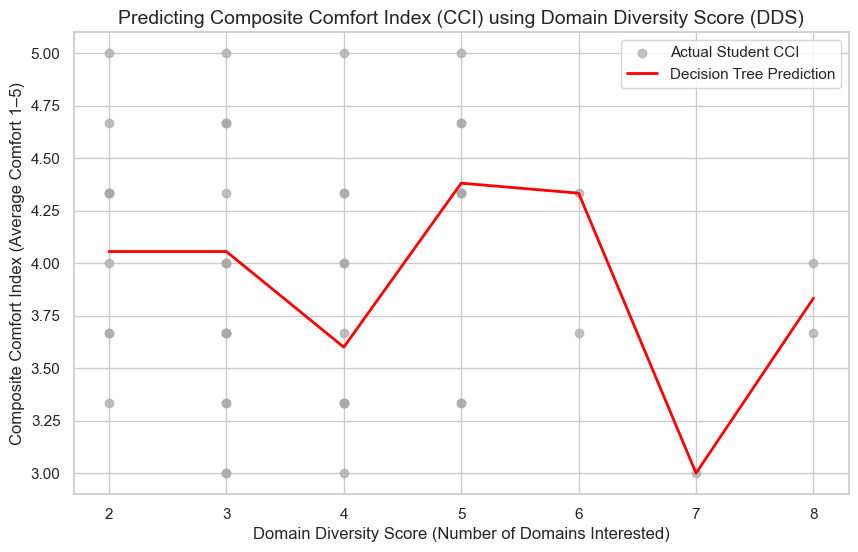

In [13]:
# 7. Visualization of Prediction

plt.figure(figsize=(10, 6))
# Get range of DDS values for prediction
dds_range = np.arange(merged['num_domains'].min(), merged['num_domains'].max() + 1).reshape(-1, 1)
# Get predicted CCI values from the model for the range
predicted_cci = dt_model.predict(dds_range)

# Scatter plot of actual CCI vs. DDS
plt.scatter(merged['num_domains'], merged['cci'], color='darkgray', alpha=0.7, label='Actual Student CCI')
# Plot the model's prediction line
plt.plot(dds_range, predicted_cci, color='red', linestyle='-', linewidth=2, label='Decision Tree Prediction')

plt.title('Predicting Composite Comfort Index (CCI) using Domain Diversity Score (DDS)', fontsize=14)
plt.xlabel('Domain Diversity Score (Number of Domains Interested)', fontsize=12)
plt.ylabel('Composite Comfort Index (Average Comfort 1–5)', fontsize=12)
plt.xticks(dds_range.flatten())
plt.legend()
plt.show()


The scatter plot shows individual students’ composite comfort index versus their domain diversity score, with actual data points in gray. The red line represents the decision tree model’s predicted comfort index for each diversity level. The prediction line is mostly flat, confirming little predictive relationship between these variables.